In [2]:
# INSTALLATION & IMPORTS
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer
from datasets import Dataset

In [3]:
# DATA LOADING
# Load dataset (last 1044 rows are test samples)
df = pd.read_parquet("group_combined_no_features.parquet")
NUM_TEST_SAMPLES = 1044
dataframe_4_bert = df[['text', 'general_emotion']].dropna()

# Labels (LabelEncoder)
label_encoder = LabelEncoder()
dataframe_4_bert["emotion_encoded"] = label_encoder.fit_transform(dataframe_4_bert["general_emotion"])
classes_ = label_encoder.classes_

# Extract the test part
test_df = dataframe_4_bert[-NUM_TEST_SAMPLES:].reset_index(drop=True)

In [4]:
# DATA PREPARATION FOR MODEL
tokenizer = RobertaTokenizer.from_pretrained("./distilroberta_finetuned_v2")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

test_dataset = Dataset.from_pandas(test_df[['text', 'emotion_encoded']])
test_dataset = test_dataset.rename_column("emotion_encoded", "labels")
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/1044 [00:00<?, ? examples/s]

In [5]:
# LOAD TRAINED MODEL
model = RobertaForSequenceClassification.from_pretrained("./distilroberta_finetuned_v2")

trainer = Trainer(
    model=model
)

In [6]:
# GET PREDICTIONS
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

In [7]:
# CLASSIFICATION REPORT
print("\n📊 Classification Report:")
print(classification_report(true_labels, preds, target_names=classes_))


📊 Classification Report:
              precision    recall  f1-score   support

       anger       0.51      0.51      0.51        37
     disgust       1.00      0.17      0.29        12
        fear       0.50      0.40      0.44         5
   happiness       0.80      0.72      0.76       385
     neutral       0.66      0.79      0.72       399
     sadness       0.55      0.55      0.55        20
    surprise       0.73      0.62      0.67       186

    accuracy                           0.71      1044
   macro avg       0.68      0.54      0.56      1044
weighted avg       0.72      0.71      0.71      1044



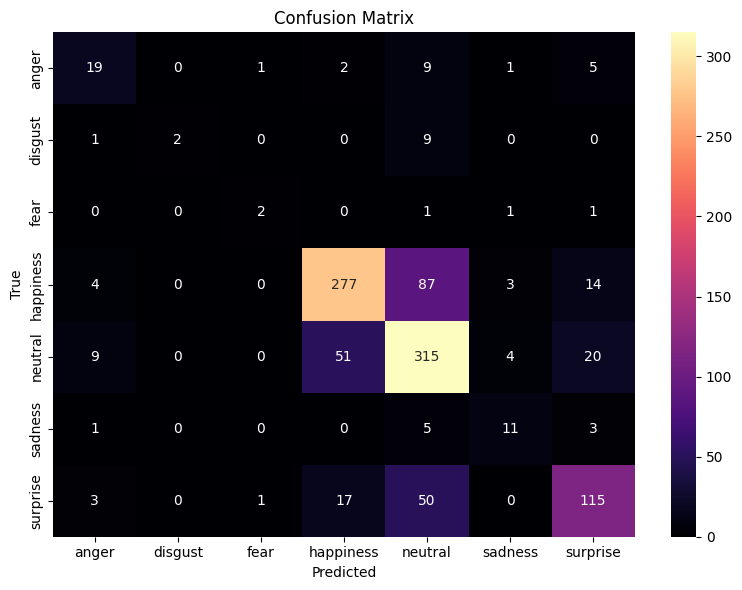

In [8]:
# CONFUSION MATRIX
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=classes_, yticklabels=classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [9]:
# ERROR ANALYSIS
# Combine everything into one DataFrame
error_df = test_df.copy()
error_df['true_label'] = [classes_[i] for i in true_labels]
error_df['predicted_label'] = [classes_[i] for i in preds]
error_df['correct'] = error_df['true_label'] == error_df['predicted_label']
error_df['text_length'] = error_df['text'].apply(lambda x: len(x.split()))

# Filter only errors
errors_only = error_df[~error_df['correct']].copy()

# Analyze the most frequent errors
error_summary = errors_only.groupby(['true_label', 'predicted_label']).size().reset_index(name='count')
error_summary = error_summary.sort_values(by='count', ascending=False)

print("\n🚨 Top 10 Most Frequent Misclassifications:")
print(error_summary.head(10))

# Save errors to file
errors_only.to_csv("model_errors_detailed.csv", index=False)
print("\n📁 Saved detailed error file to 'model_errors_detailed.csv'")


🚨 Top 10 Most Frequent Misclassifications:
   true_label predicted_label  count
11  happiness         neutral     87
15    neutral       happiness     51
24   surprise         neutral     50
17    neutral        surprise     20
23   surprise       happiness     17
13  happiness        surprise     14
2       anger         neutral      9
6     disgust         neutral      9
14    neutral           anger      9
4       anger        surprise      5

📁 Saved detailed error file to 'model_errors_detailed.csv'
